<a href="https://colab.research.google.com/github/teemkwong/MachineLearning/blob/master/nlp_work_1_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This nlp work followed the idea from the below URL to cluster the universities and institutions names.
https://github.com/dipanjanS/adv_nlp_workshop_odsc_europe22/blob/main/01_Text_Representation_Word_Embedding_Models.ipynb

# Here is the idea as follows:

1.	Tokenized the name by removing noises, such as special characters, extra whitespaces, digits, stop words and converting all remaining characters to lowercase.
2.	Create word embedding representations by using Word2vec algorithm from Gensim library. It is a predictive deep learning-based model to compute and generate high quality, distributed and continuous dense vector representations of words, which capture contextual and semantic similarity. I can use the cosine similarity to indicate the level of semantic similarity between the word vectors.
3.	Create name level embedding by summing up all corresponding word level embeddings.
4.	Cluster all name level embedding using an unsupervised clustering algorithm called Affinity Propagation algorithm.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# visualize embeddings
from sklearn.manifold import TSNE

pd.options.display.max_colwidth = 200

docs = pd.read_csv('doc_2022.csv')
corpus = docs['affilname']

split_corpus = corpus.str.split(';')
np_corpus = split_corpus.to_numpy()
flatten_corpus = np.hstack(np_corpus)
flatten_corpus = np.unique(flatten_corpus)

corpus_df = pd.DataFrame({'Document': flatten_corpus})
corpus_df

,Document
0,Accounting
1,"Advanced Instrument, Ministry of Education"
2,Burke Construction Limited
3,Complex System
4,"Design Institute CO., LTD."
...,...
1610,École Normale Supérieure
1611,École des hautes études commerciales de Paris
1612,Écoles polytechniques fédérales
1613,İstanbul Teknik Üniversitesi


In [ ]:
import nltk
import re

nltk.download('stopwords')
nltk.download('punkt')

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, flags=re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(flatten_corpus)
norm_corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


array(['accounting', 'advanced instrument ministry education',
       'burke construction limited', ..., 'coles polytechniques fdrales',
       'stanbul teknik niversitesi',
       'coala naional de studii politice administrative'], dtype='<U108')

In [ ]:
tokenized_corpus = [nltk.word_tokenize(doc) for doc in norm_corpus]
tokenized_corpus

[['accounting'],
 ['advanced', 'instrument', 'ministry', 'education'],
 ['burke', 'construction', 'limited'],
 ['complex', 'system'],
 ['design', 'institute', 'co', 'ltd'],
 ['information', 'technology'],
 ['innovation'],
 ['mary'],
 ['medicine'],
 ['molecular', 'engineering'],
 ['peking', 'union', 'medical', 'college'],
 ['reconstruction'],
 ['remote', 'sensing', 'tu', 'delft'],
 ['technical', 'college', 'nonferrous', 'metallurgy'],
 ['technology'],
 ['technology', 'misis'],
 ['technology', 'facility'],
 ['technology',
  'innovation',
  'laboratory',
  'optoelectronic',
  'information',
  'china'],
 ['technology', 'beijing'],
 ['tropical', 'medicine'],
 ['water', 'research', 'institute'],
 ['paradigm', 'inc'],
 ['astar', 'genome', 'institute', 'singapore'],
 ['astar', 'institute', 'high', 'performance', 'computing'],
 ['astar', 'institute', 'microelectronics'],
 ['astar', 'institute', 'molecular', 'cell', 'biology'],
 ['astar', 'singapore', 'institute', 'manufacturing', 'technology'],

In [ ]:
import gensim
gensim.__version__

'3.6.0'

# Robust Word2Vec Model with Gensim

In [ ]:
from gensim.models import word2vec

# Set values for various parameters
feature_size = 300   # Word vector dimensionality  every word -> [......] -> 15
window_context = 5   # Context window size
min_word_count = 1   # Minimum word count
sg = 1               # skip-gram model if sg = 1 and CBOW if sg = 0

w2v_model = word2vec.Word2Vec(tokenized_corpus,
                              size=feature_size,
                              window=window_context,
                              min_count = min_word_count,
                              sg=sg, iter=300)
print(w2v_model)

Word2Vec(vocab=1897, size=300, alpha=0.025)


In [ ]:
print(w2v_model.wv.most_similar('university'))
# print(len(w2v_model.wv.index2word))

[('belfast', 0.511268675327301), ('nanolund', 0.48781517148017883), ('commonwealth', 0.4809432625770569), ('wellington', 0.47528180480003357), ('dame', 0.4556769132614136), ('tel', 0.4520271122455597), ('cape', 0.44031357765197754), ('kyung', 0.4361007809638977), ('stony', 0.4346073865890503), ('brigham', 0.43418413400650024)]


# Looking at term semantic similarity

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

vec_df = pd.DataFrame(wvs, index=words)

similarity_matrix = cosine_similarity(vec_df.values)
similarity_df = pd.DataFrame(similarity_matrix, index=words, columns=words)
similarity_df

,university,institute,technology,research,sciences,school,science,laboratory,national,de,...,commerciales,coles,polytechniques,fdrales,stanbul,teknik,coala,naional,studii,politice
university,1.000000,0.061061,0.171053,0.161881,0.157496,0.147439,0.180694,0.132439,0.195689,0.074994,...,0.015605,0.001371,0.040727,0.012661,0.113194,0.116287,0.087146,0.097264,0.097297,0.115034
institute,0.061061,1.000000,0.337397,0.350401,0.247355,0.175666,0.219116,0.212114,0.185689,0.101587,...,0.134688,0.032086,0.054878,0.050430,0.117865,0.121511,0.078810,0.077782,0.079443,0.089055
technology,0.171053,0.337397,1.000000,0.201767,0.165788,0.137579,0.465789,0.240638,0.191342,0.074312,...,0.068481,0.039522,0.062801,0.071754,0.087747,0.095026,0.110570,0.109188,0.113253,0.117602
research,0.161881,0.350401,0.201767,1.000000,0.164895,0.315906,0.175335,0.217532,0.252929,0.066822,...,0.167851,0.008021,0.030398,0.034129,0.049530,0.077679,0.053908,0.050618,0.061006,0.069836
sciences,0.157496,0.247355,0.165788,0.164895,1.000000,0.309140,0.415480,0.169111,0.202217,0.260171,...,0.359940,0.060385,0.050320,0.038537,0.017990,0.016288,0.121824,0.118700,0.120960,0.133629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
teknik,0.116287,0.121511,0.095026,0.077679,0.016288,0.200646,0.056523,0.178154,0.030807,0.310633,...,0.566055,0.884672,0.890228,0.894735,0.993655,1.000000,0.575085,0.574674,0.559829,0.553762
coala,0.087146,0.078810,0.110570,0.053908,0.121824,0.128484,0.093015,0.165154,0.198343,0.619442,...,0.684111,0.650360,0.630513,0.630685,0.586799,0.575085,1.000000,0.998653,0.998558,0.997687
naional,0.097264,0.077782,0.109188,0.050618,0.118700,0.122867,0.093393,0.157130,0.195598,0.623953,...,0.672980,0.648566,0.628536,0.628091,0.587507,0.574674,0.998653,1.000000,0.998439,0.998521
studii,0.097297,0.079443,0.113253,0.061006,0.120960,0.113611,0.096182,0.163876,0.202747,0.604842,...,0.674527,0.632313,0.612806,0.614045,0.570835,0.559829,0.998558,0.998439,1.000000,0.998867


In [ ]:
feature_names = np.array(words)
similarity_df.apply(lambda row: feature_names[np.argsort(-row.values)[1:5]], 
                    axis=1)

university    [belfast, nanolund, commonwealth, wellington]
institute               [enrico, boskovic, james, teachers]
technology                 [teachers, birla, mesra, metals]
research               [flanders, hydraulics, riken, cairo]
sciences             [academy, polish, oceanology, mapping]
                                  ...                      
teknik                    [stanbul, bilkent, boazii, firat]
coala           [naional, studii, politice, administrative]
naional           [coala, politice, studii, administrative]
studii           [politice, coala, naional, administrative]
politice           [studii, naional, coala, administrative]
Length: 1897, dtype: object

# Getting document level embeddings

In [ ]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64") # avg embedding for the tokenized doc
    nwords = 0.
    
    for word in words: # for every word in a document, find the word embedding and add it to feature_vector
        if word in vocabulary: 
            nwords = nwords + 1.    # 1 + 1 + 1 = 3
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)  # 1x15 / 3
    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word) # set of unique words across the corpus
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [ ]:
model_be_trained = w2v_model
# get document level embeddings
w2v_doc_features = averaged_word_vectorizer(corpus=tokenized_corpus, 
                                           model=model_be_trained,
                                           num_features=feature_size)
pd.DataFrame(w2v_doc_features)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000007,-0.000625,0.000055,-0.000957,0.001301,0.000553,-0.000298,0.001548,0.000727,0.001154,...,0.000449,0.000260,-0.000594,0.000621,-0.000359,0.000983,0.001343,0.001141,-0.001563,0.000681
1,-0.185983,-0.220899,0.164303,0.051898,-0.129194,0.013517,0.241319,-0.353094,-0.376173,-0.012424,...,0.013698,0.245033,0.139319,-0.539069,-0.768158,0.024108,0.179721,-0.461014,-0.240892,-0.723930
2,0.077972,0.186884,0.149279,0.224806,-0.450242,-0.082387,-0.078854,0.129081,-0.321967,-0.111443,...,-0.156652,0.312415,-0.117612,-0.128826,-0.160674,0.212537,-0.201425,0.003809,-0.240365,-0.178530
3,0.049351,-0.029380,0.152452,0.266224,-0.255089,-0.314330,-0.014132,-0.094302,-0.180480,0.464433,...,0.060164,0.408142,-0.259869,-0.472637,-0.460172,-0.104216,0.510255,-0.132659,-0.359139,-0.563672
4,-0.146892,0.002236,-0.122277,0.161675,-0.024023,0.085586,0.114140,-0.152136,-0.082228,-0.144586,...,0.040866,0.136280,0.117899,0.095482,-0.274107,0.195059,-0.151104,-0.352929,-0.115208,-0.405933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610,-0.260960,0.169964,-0.291510,0.156115,-0.117365,0.000298,0.289824,0.019403,-0.104008,0.000481,...,-0.009814,0.461454,-0.115715,0.244236,0.044014,0.105241,-0.249186,0.148226,0.068723,-0.162497
1611,-0.229133,0.212148,-0.297613,0.224107,0.007194,-0.024574,0.430374,-0.037731,-0.193412,-0.038126,...,0.020615,0.666318,-0.109546,0.253643,-0.038806,0.033711,-0.314102,0.172377,0.110228,-0.285880
1612,-0.112004,0.041102,0.038539,0.057607,-0.217231,-0.032262,0.070765,-0.008167,-0.105326,0.124447,...,-0.032135,0.287305,-0.117336,0.118571,0.065178,0.151845,-0.095174,0.117409,-0.095230,-0.041130
1613,-0.213171,0.119048,-0.064055,0.111793,-0.209859,-0.054008,0.055250,-0.146606,-0.077680,0.224445,...,0.110813,0.342252,-0.033394,0.068824,0.053320,0.431093,-0.084702,0.113025,-0.271174,0.079325


# Trying out document clustering

In [ ]:
from sklearn.cluster import AffinityPropagation

w2v_ap = AffinityPropagation()
w2v_ap.fit(w2v_doc_features)

w2v_cluster_labels = w2v_ap.labels_
w2v_cluster_labels = pd.DataFrame(w2v_cluster_labels, 
                              columns=['ClusterLabel'])

w2v_cluster_result = pd.concat([corpus_df, w2v_cluster_labels], axis=1)
print(w2v_cluster_result)

                                                   Document  ClusterLabel
0                                                Accounting            46
1                Advanced Instrument, Ministry of Education            40
2                                Burke Construction Limited             0
3                                            Complex System            69
4                                Design Institute CO., LTD.            12
...                                                     ...           ...
1610                               École Normale Supérieure            23
1611          École des hautes études commerciales de Paris            99
1612                        Écoles polytechniques fédérales            23
1613                           İstanbul Teknik Üniversitesi            23
1614  Școala Naţională de Studii Politice și Administrative            16

[1615 rows x 2 columns]


In [ ]:
print(len(set(w2v_cluster_result['ClusterLabel'])))
print(w2v_cluster_result[w2v_cluster_result['ClusterLabel'] == 1])

101
                             Document  ClusterLabel
21                     4Paradigm Inc.             1
44                         Adobe Inc.             1
82                        Baidu, Inc.             1
312         Enkris Semiconductor Inc.             1
319                    Facebook, Inc.             1
336                    Fibertek, Inc.             1
535       Inc. 805 Middlesex Turnpike             1
872                      NetEase Inc.             1
900             OG Technologies, Inc.             1
907  OpenEye Scientific Software, Inc             1


101


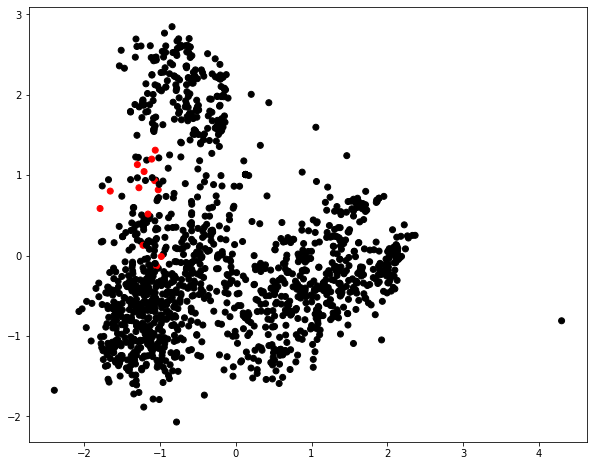

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(w2v_doc_features)
labels = w2v_ap.labels_
print(len(set(labels)))
colors = np.where(labels == 0, 'r', 'k')
categories = list(flatten_corpus)
plt.figure(figsize=(10, 8))

x = pcs[:,0]
y = pcs[:,1]

# plt.scatter(x, y)
plt.scatter(x, y, c=colors)
# plt.annotate(categories, xy=(x+1e-2, y+1e-2))

# for i in range(len(labels)):
#     # label = labels[i]
#     # color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
#     # color = 'orange'
#     annotation_label = categories[i]
#     x, y = pcs[i]
#     plt.scatter(x, y, c=labels[i], edgecolors='k')
#     plt.annotate(annotation_label, xy=(x+1e-2, y+1e-2), xytext=(0, 0), 
#                  textcoords='offset points')